### Imports and Settings

In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

import SAGA
from SAGA.database import FitsTable
from easyquery import Query
from easyquery import QueryMaker
from SAGA import ObjectCuts as C

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}

plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['legend.frameon'] = False
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 4

### Load SAGA Data

In [5]:
def Mr_from_r(r,host_dist):
    return r - 5.*np.log10(host_dist) - 25.

In [3]:
saga = SAGA.QuickStart()
saga.set_default_base_version("paper2")

hosts = saga.host_catalog.load(include_stats=True)
paper1_hosts = np.array(['nsa166313', 'nsa147100', 'nsa165536', 'nsa61945', 'nsa132339',
                         'nsa149781', 'nsa33446', 'nsa150887'])

SAGA `shared_dir` set to /Users/eon/Documents/PaperII
SAGA `local_dir`  set to /Users/eon/Documents/PaperII


In [4]:
completed_hosts = saga.host_catalog.load(query="paper2_complete", include_stats="remote")
observed_hosts = saga.host_catalog.load(query="paper2_observed", include_stats="remote")
bright_completed_hosts = saga.host_catalog.load(query="paper2_bright_complete", include_stats="remote")

url = "https://www.dropbox.com/sh/7qeuqkq0c591k2g/AADUIE4j1t2vXqKpaHoCY0L7a/saga_observed_latest.fits?dl=1"
specs_and_potential_sats = FitsTable(url).read()

specs = C.has_spec.filter(specs_and_potential_sats)
possible_sats = (~C.has_spec).filter(specs_and_potential_sats)

sats_this_host = {}
possible_sats_this_host = {}

hosts = set(specs_and_potential_sats["HOSTID"])
for host in hosts:
    sats_this_host[host] = (QueryMaker.equals("HOSTID", host) & C.is_sat).filter(specs_and_potential_sats)
    possible_sats_this_host[host] = (QueryMaker.equals("HOSTID", host)&(~C.has_spec)).filter(specs_and_potential_sats)

In [19]:
num_draws = 10000

sats_num_draws = {}
mean = {}

for host in completed_hosts:
    sats_num_draws[host['HOSTID']] = []
    Mr_possible = Mr_from_r(possible_sats_this_host[host['HOSTID']]['r_mag'],
                            possible_sats_this_host[host['HOSTID']]['HOST_DIST'])
    psat_possible = np.array(possible_sats_this_host[host['HOSTID']]['p_sat_corrected'][Mr_possible<-12.3])
    for j in range(num_draws):
        rands = np.random.rand(len(psat_possible))
        sats_num_draws[host['HOSTID']].append(1.*host['sats_Mr_limit']+1.*len(rands[rands<psat_possible]))
    mean[host['HOSTID']] = np.mean(np.array(sats_num_draws[host['HOSTID']]))

In [23]:
### MW 
mw = np.recfromcsv('EON_data/mw_sats_master.csv')
MW = {}
MW['M_K'] = -24.0
MW['m_v'] = mw['m_v'][mw['type2']>=3]

### M31
M31 = {}
M31['M_K'] = -24.7
M31['m_v'] = np.array([-18.8,-16.5,-16.3,-15.8,-15.0,-15.5,-13.2,-12.5,-12.7,-12.0,-11.8,-10.2,-9.9,-11.5,-9.2,-9.2,
                      -10.1,-8.4,-9.5,-10.1,-8.8,-8.1,-8.5,-8.8,-8.0,-8.0,-10.2,-8.8,-9.2])

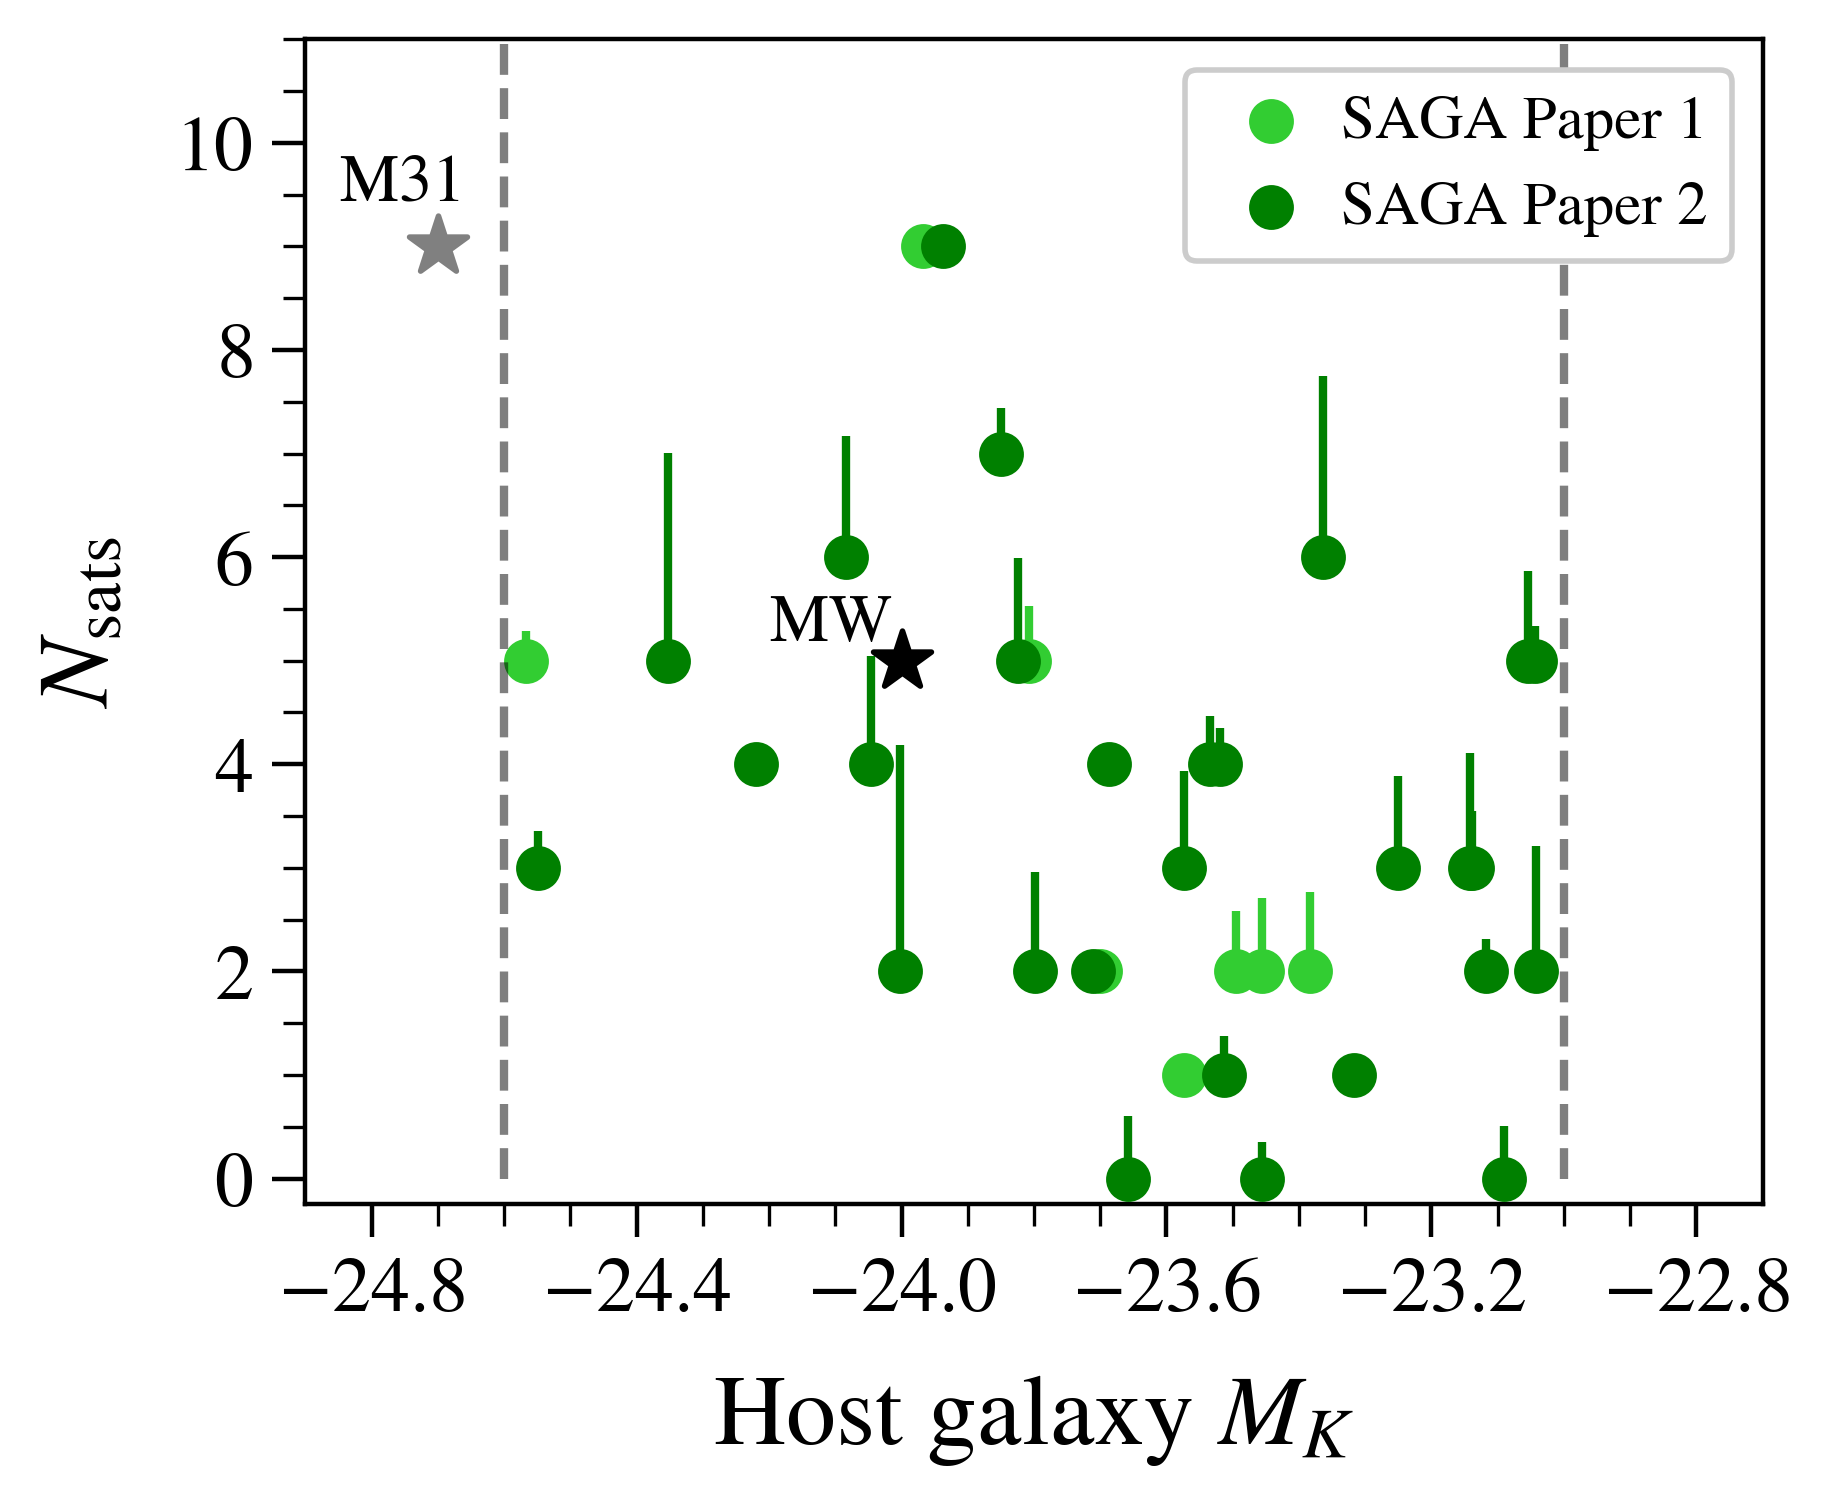

In [28]:
plt.figure(figsize=(4.8,4.))

for host in completed_hosts:
    if host['HOSTID'] in paper1_hosts:
        paper1 = plt.scatter(host['K_ABS'],host['sats_Mr_limit'],color='limegreen',s=50,zorder=2,label=r'SAGA Paper 1')
        plotline1,caplines1,barlinecols1 = plt.errorbar(host['K_ABS'],host['sats_Mr_limit'],
                                                        yerr=mean[host['HOSTID']]-host['sats_Mr_limit'],lolims=True,
                                                        color='limegreen',zorder=1)
    elif host['HOSTID'] == 'nsa147606':
        plt.scatter(0.04+host['K_ABS'],host['sats_Mr_limit'],color='g',s=50,zorder=999)
        plotline1,caplines1,barlinecols1 = plt.errorbar(0.04+host['K_ABS'],host['sats_Mr_limit'],
                                                        yerr=mean[host['HOSTID']]-host['sats_Mr_limit'],lolims=True,
                                                        color='g',zorder=1)
    else:
        paper2 = plt.scatter(host['K_ABS'],host['sats_Mr_limit'],color='g',s=50,zorder=999,label=r'SAGA Paper 2')
        plotline1,caplines1,barlinecols1 = plt.errorbar(host['K_ABS'],host['sats_Mr_limit'],
                                                        yerr=mean[host['HOSTID']]-host['sats_Mr_limit'],lolims=True,
                                                        color='g',zorder=1)
    caplines1[0].set_marker('_')
    caplines1[0].set_markersize(0)

#MW
plt.scatter(MW['M_K'],1+len(MW['m_v'][MW['m_v']<-12.1]),facecolor='k',edgecolor='k',marker='*',s=120,zorder=999)
plt.text(-24.2,5.2,r'$\mathrm{MW}$',c='k',fontweight='bold',fontsize=12)

#M31
plt.scatter(M31['M_K'],len(M31['m_v'][M31['m_v']<-12.1]),facecolor='gray',edgecolor='gray',marker='*',s=120)
plt.text(-24.85,9.45,r'$\mathrm{M31}$',c='k',fontweight='bold',fontsize=12)

plt.plot(np.ones(10)*-23.0,np.linspace(0,11.5,10),'k--',alpha=0.5)
plt.plot(np.ones(10)*-24.6,np.linspace(0,11.5,10),'k--',alpha=0.5)

#Ticks, labels, etc.
plt.xlim(-24.9,-22.7)
plt.ylim(-0.25,11.0)

plt.xticks([-24.8,-24.4,-24.0,-23.6,-23.2,-22.8],[r'$-24.8$',r'$-24.4$',r'$-24.0$',r'$-23.6$',r'$-23.2$',r'$-22.8$'],
           fontsize=14)
plt.yticks([0,2,4,6,8,10],[r'$0$',r'$2$',r'$4$',r'$6$',r'$8$',r'$10$'],fontsize=14)

plt.xlabel(r'Host galaxy $M_K$',fontsize=18,labelpad=8)
plt.ylabel(r'$N_{\rm{sats}}$',fontsize=18,labelpad=8)

legend = plt.legend(loc=1,handles=[paper1,paper2],fontsize=11,frameon=True,handletextpad=0.15,
                    bbox_to_anchor=(1.0,1.0),framealpha=1.0)
legend.get_frame().set_linewidth(1.0)

plt.tight_layout()
plt.savefig('num_sat_host_mk_new.pdf')
plt.show()